### Imports

In [1]:

import pickle as pkl
import pandas as pd
import pandas
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec 
import rouge
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional, Dropout, Input, concatenate, Reshape, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import tensorflow.keras.backend as K


### Loading Data

In [2]:
data = pd.read_pickle('data/tokenized.pkl')
eval_df = pd.read_pickle('data/evaluation.pkl')
data

,Unnamed: 0,publication,content
0,0,New York Times,"[washington, —, congressional, republicans, ha..."
1,1,New York Times,"[after, the, bullet, shells, get, the, south, ..."
2,2,New York Times,"[when, walt, disney, ’, s, but, what, they, di..."
3,3,New York Times,"[death, may, be, the, great, equalizer, ,, but..."
4,4,New York Times,"[seoul, ,, south, korea, —, although, north, k..."
...,...,...,...
47220,47220,BBC_tech,"[bt, is, introducing, two, initiatives, from, ..."
47221,47221,BBC_tech,"[computer, users, across, the, world, more, th..."
47222,47222,BBC_tech,"[a, new, european, directive, could, if, it, g..."
47223,47223,BBC_tech,"[the, man, making, sure, us, amit, yoran, was,..."


In [3]:
all_sentences = list(data['content'])
all_sentences.extend(list(eval_df['content']))

### Getting Relevant publications

In [4]:
# selected_publications = [
#  'Breitbart',
#  'CNN',
#  'New York Times',
#  'NPR',
#  'Fox News',
#  'Reuters']
selected_publications = [
 'Breitbart',
 'CNN',
 'New York Times']

In [5]:
all_publications = list(set(data['publication']))
all_publications

['BBC_business',
 'Atlantic',
 'BBC_entertainment',
 'Buzzfeed News',
 'BBC_sport',
 'Guardian',
 'BBC_tech',
 'Breitbart',
 'Business Insider',
 'National Review',
 'New York Post',
 'Reuters',
 'Fox News',
 'New York Times',
 'Vox',
 'Washington Post',
 'Talking Points Memo',
 'NPR',
 'CNN',
 'BBC_politics']

In [6]:
# Take only the contents from publications with >= 3000 samples.
publications = [pub for pub in selected_publications if pub in all_publications and len(data[data['publication'] == pub]) >= 3000]
publications

['Breitbart', 'CNN', 'New York Times']

In [7]:
contents = []
for pub in publications:
    contents.append(np.asarray(data[data['publication'] == pub]['content']))

### Padding with special Character

In [8]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

In [9]:
end_token = '~?@_'

In [10]:
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))

In [11]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

### Vectorize Words

In [12]:
word_dim = 100

In [13]:

word2vec = gensim.models.Word2Vec(all_sentences, min_count = 1,  
                              size = word_dim, window = 5) 

In [14]:
print("Cosine similarity between 'congress' " + 
               "and 'senate' - CBOW : ", 
    word2vec.wv.similarity('congress', 'senate')) 
      
print("Cosine similarity between 'congress' " +
                 "and 'house' - CBOW : ", 
    word2vec.wv.similarity('congress', 'house')) 

Cosine similarity between 'congress' and 'senate' - CBOW :  0.7506351
Cosine similarity between 'congress' and 'house' - CBOW :  0.62278795


In [15]:
word2vec.wv['congressional']

array([ 0.2737055 , -0.0815997 , -0.40515476,  0.10907958, -0.10488369,
       -0.46514127,  0.3546361 , -0.49898246, -0.13679565, -0.95021194,
        0.11053801,  0.28043687,  0.39044622,  0.18986215,  0.31135228,
        0.65644604, -0.53040445,  0.09304625, -0.33855414,  1.5273463 ,
       -1.550524  ,  0.8062989 ,  0.27642545, -0.655483  ,  0.59252894,
       -0.29950106, -0.10941707, -1.2045021 , -0.7059632 ,  0.05883586,
        0.27209347, -0.7489524 , -0.28490993, -0.5156418 ,  0.11626618,
       -0.3572677 ,  0.03211268,  0.07818181, -0.51545733, -0.13020003,
        0.1085882 , -1.5130123 ,  0.297752  , -0.5476296 ,  0.37076122,
        0.8633128 , -0.20785286, -0.68780774,  0.73181003, -0.8301219 ,
        0.05571607, -0.42777744, -0.12656578,  0.7455623 ,  0.36209732,
       -0.32334244, -0.31440073,  0.4286173 , -1.4040293 ,  0.34348148,
        0.05970663, -0.36402565, -0.15024659,  0.07058263,  0.5764989 ,
        0.985047  ,  0.57990754,  1.5233004 ,  1.2298111 , -0.22

In [16]:
word2vec.wv.similar_by_vector(word2vec.wv['congressional'])

[('congressional', 1.0000001192092896),
 ('senate', 0.8786221146583557),
 ('judiciary', 0.8456677198410034),
 ('committee', 0.8444260954856873),
 ('conservative', 0.8296844959259033),
 ('gop', 0.821047842502594),
 ('liberal', 0.8202149868011475),
 ('lawmakers', 0.8164830803871155),
 ('272-219', 0.8096722364425659),
 ('governors', 0.8080213665962219)]

In [17]:
contents = np.asarray(contents)

In [18]:
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

In [19]:
for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

In [20]:
# TODO use closest cosine distance to find output word.

## Funciton Definitions

In [21]:
def squareError(xTrue, xPred):
    return K.square(xTrue - xPred)


In [23]:
def reconstructionLoss(sample, encoder, decoder, f_w, weight): # (L_1 from the paper)
    return K.mean(squareError(sample, decode_sequence(encoder(sample), decoder, sample.shape[1], sample.shape[2]))) + K.mean(weight*K.log(f_w(encoder(sample))))

In [24]:
def divergenceLoss(f_w, encoder, sample, z_j, n_j): # Mean of log f_w(E_theta_i(x_j)) + log (1-f_w(z_j, n_j)) from the paper (L_2).
    return K.mean(K.log(f_w(encoder(sample)))) + K.mean(K.log(1 - f_w(z_j + n_j)))


In [25]:
def sample(data, domain, num_samples):
    N = data.shape[1]
    return tf.convert_to_tensor(data[domain, np.random.choice(N, num_samples, replace=True),:,:], dtype=tf.float32)


In [26]:
# Currently just doing a restriction to the last z variables, might want to do a matrix multiplication?
# pi_Z from the paper. projects a latent distribution in (z, n) to z
def projectZ(encoded):
    return encoded[0:2] # take zs.

In [27]:
def projectN(encoded):
    return encoded[2:4] # take ns.

In [28]:
# # takes in two inputs, n and z, and outputs samples.
# def createDecoder(z_dims, n_dims, time_steps, output_dims):
#     # TODO MAYBE: Add in more regularization or different than dropout?

#     z_inputs = Input(shape=(z_dims,))
#     n_inputs = Input(shape=(n_dims,))
#     inputs = concatenate([z_inputs, n_inputs])
# #     # 150 is arbitrary rn...
# #     dense = Dense(150)(inputs)
#     dense = Dense(time_steps*output_dims)(inputs)
#     reshape = Reshape((time_steps, output_dims))(dense)
#     # TODO Reshape to enforce time_steps?
#     bilstm = Bidirectional(LSTM(64, activation='tanh', return_sequences=True))(reshape)
#     bilstm = Dropout(0.2)(bilstm)
#     bilstm = Bidirectional(LSTM(64, activation='tanh', return_sequences=False))(bilstm)
#     bilstm = Dropout(0.2)(bilstm)
    
#     dense = Dense(time_steps*output_dims, activation='linear')(bilstm)
#     outputs = Reshape((time_steps, output_dims))(dense)
    
#     model = Model(inputs=[z_inputs, n_inputs], outputs=outputs)
    
#     return model

In [29]:
def createEncoder(time_steps, input_num, z_dims, n_dims):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(time_steps, input_num))
    z_encoder = LSTM(z_dims, return_state=True)
    n_encoder = LSTM(n_dims, return_state=True)
    
    z_encoder_outputs, z_state_h, z_state_c = z_encoder(encoder_inputs)
    n_encoder_outputs, n_state_h, n_state_c = n_encoder(encoder_inputs)
    
    # We discard `encoder_outputs` and only keep the states.
    z_encoder_states = [z_state_h, z_state_c]
    n_encoder_states = [n_state_h, n_state_c]
    
    model = Model(inputs=encoder_inputs, outputs=z_encoder_states + n_encoder_states)
    
    return model


In [75]:
def createDecoder(z_dims, n_dims, time_steps, output_dims):
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(1, output_dims,))
    
    z_state_h = Input(shape=(z_dims,))
    z_state_c = Input(shape=(z_dims,))
    n_state_h = Input(shape=(n_dims,))
    n_state_c = Input(shape=(n_dims,))
    
    z_encoder_states = [z_state_h, z_state_c]
    n_encoder_states = [n_state_h, n_state_c]
    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    z_decoder_lstm = LSTM(z_dims, return_sequences=True, return_state=True)
    n_decoder_lstm = LSTM(n_dims, return_sequences=True, return_state=True)
    z_decoder_outputs, z_state_h, z_state_c = z_decoder_lstm(decoder_inputs,
                                         initial_state=z_encoder_states)
    n_decoder_outputs, n_state_h, n_state_c = n_decoder_lstm(decoder_inputs,
                                         initial_state=n_encoder_states)
    
    decoder_outputs = concatenate([z_decoder_outputs, n_decoder_outputs])
    
    z_decoder_states = [z_state_h, z_state_c]
    n_decoder_states = [n_state_h, n_state_c]
    
    decoder_dense = Dense(output_dims, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model(inputs=[decoder_inputs] + z_encoder_states + n_encoder_states,
                  outputs=[decoder_outputs] + z_decoder_states + n_decoder_states)
    
    return model

In [ ]:
def createEncDecModel(encoder, decoder, time_steps, dims):
    encoder_inputs = Input(shape=(time_steps, dims))
    decoder_inputs = Input(shape=(1, dims,))
    
    enc = encoder(encoder_inputs)
    dec = createDecoder(decoder_inputs + enc)
    model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = dec)
    
    return model
    

In [155]:
def decode_sequence(encoder_outputs, decoder, time_steps, dims):
    batch_size = encoder_outputs[0].shape[0]
    
    states_value = encoder_outputs

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((batch_size, 1, dims))
    # Populate the first character of target sequence with the start character.
#     target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = np.zeros((batch_size, time_steps, dims))
    
    index = 0
    while index < time_steps:
        output_vec, z_state_h, z_state_c, n_state_h, n_state_c = decoder.predict(
            [target_seq] + states_value)

        # Sample a token
        decoded_sentence[:, index, :] = output_vec.reshape((batch_size, dims))

        
            
            
        target_seq = np.zeros((batch_size, 1, dims))
        
        for i in range(batch_size):
            
            # Update the target sequence (of length 1).
            word = word2vec.wv.similar_by_vector(output_vec[i, 0, :])[0][0]

            target_seq[i, 0, :] = word2vec.wv[word]

        # Update states
        states_value = [z_state_h, z_state_c, n_state_h, n_state_c]
        index += 1

    return decoded_sentence

In [156]:
# def createEncoder(time_steps, input_num, z_dims, n_dims):
#     # TODO MAYBE: Add in more regularization or different than dropout?
#     inputs = Input(shape=(time_steps, input_num,))
#     bilstm = Bidirectional(LSTM(64, activation='tanh', return_sequences=True))(inputs)
#     bilstm = Dropout(0.2)(bilstm)
#     dense = Bidirectional(LSTM(64, activation='tanh', return_sequences=False))(bilstm)
#     dense = Dropout(0.2)(dense)
#     z_output = Dense(z_dims, activation='linear')(dense)
#     n_output = Dense(n_dims, activation='linear')(dense)
    
#     model = Model(inputs=inputs, outputs=[z_output, n_output])
    
#     return model

In [157]:
def createDiscriminator(z_dims, n_dims):
    
    z_inputs_h = Input(shape=(z_dims,))
    z_inputs_c = Input(shape=(z_dims,))
    n_inputs_h = Input(shape=(n_dims,))
    n_inputs_c = Input(shape=(n_dims,))
    
    inputs = concatenate([z_inputs_h, z_inputs_c, n_inputs_h, n_inputs_c])
    
    # 150, 100 is arbitrary rn...
    dense = Dense(150, activation='relu')(inputs)
    dense = Dense(100, activation='relu')(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[z_inputs_h, z_inputs_c, n_inputs_h, n_inputs_c], outputs=output)
    
    return model

In [158]:
lr = 5e-4
enc_optimizer = tf.keras.optimizers.Adam(lr)
dec_optimizer = tf.keras.optimizers.Adam(lr)
disc_optimizer = tf.keras.optimizers.Adam(lr)

### When $P_Z$ is known... 

In [159]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# original_domains is a list of the original domains P_z was derived from.

# Currently assuming P_Z is known. Must approximate P_Z first.
def trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=10, weight=1.0):
    N = samples.shape[1]
    k = samples.shape[0]
        
    
    for i in range(k):
        if i not in original_domains:
            original_domain = np.random.choice(original_domains)
            encoder = encoders[i]
            decoder = decoders[i]
            original_encoder = encoders[original_domain]
            epoch = 0
            while(epoch < epochs): # TOOD: could also do until some convergence criteria.
                p_Xi_samples = sample(samples, i, num_samples)
                p_Z_samples = projectZ(original_encoder(sample(samples, original_domain, num_samples)))
                p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                    reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)

                    # negative b/c gradient ascent.
                    divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Z_samples, p_Ni_samples)

                gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)


                enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                
                print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                epoch+=1
            

### When $P_Z$ is unknown...
"A straight-forward approach for learning the latent distribution PZ is to train a regularized autoencoder on data from a
single representative domain. However, such a representation could potentially capture variability that is specific to
that one domain. To learn a more invariant latent representation, we propose the following extension of our autoencoder
framework. The basic idea is to alternate between training
multiple autoencoders until they agree on a latent representation that is effective for their respective domains. This is
particularly relevant for applications to biology; for example, often one is interested in learning a latent representation
that integrates all of the data modalities."

In [160]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# domains is a list of the domains we are currently training over.

def trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, domains, epochs=10, weight=1.0):
    N = samples.shape[1]
    k = samples.shape[0]
    
    for i in domains:
        encoder = encoders[i]
        decoder = decoders[i]
        for j in domains:
            if i != j:
                j_encoder = encoders[j]
                epoch = 0
                while(epoch < epochs): # TOOD: could also do until some convergence criteria.
                    p_Xi_samples = sample(samples, i, num_samples)
                    p_Zj_samples = projectZ(j_encoder(sample(samples, j, num_samples)))
                    p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                        reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)
#                         print(p_Xi_samples)

                        # negative b/c gradient ascent.
                        divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Zj_samples, p_Ni_samples)
#                         print(p_Zj_samples)
#                         print(p_Ni_samples)
                        
                    gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                    gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                    gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)
            

                    enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                    dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                    
                    print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                    epoch+=1
            

In [161]:
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep

def initModel(samples, z_dims, n_dims):
    
    k = samples.shape[0]
    N = samples.shape[1]
    time_steps = samples.shape[2]
    dim = samples.shape[3]
    
    
    
    discriminator = createDiscriminator(z_dims, n_dims)
    
    encoders = []
    decoders = []
    
    for i in range(k):
        encoders.append(createEncoder(time_steps, dim, z_dims, n_dims))
        decoders.append(createDecoder(z_dims, n_dims, time_steps, dim))
    
    return encoders, decoders, discriminator

In [162]:
def translate(start_sequences, samples, encoders, decoders, start_domain, end_domain):
    time_steps = start_sequences.shape[1]
    dims = start_sequences.shape[2]
    
    N = samples.shape[1]
    print(start_sequences.shape)
    num_samples = start_sequences.shape[0]
    
    start_encoder = encoders[start_domain]
    end_encoder = encoders[end_domain]
    end_decoder = decoders[end_domain]
    
    z = projectZ(start_encoder(start_sequences))
    n = projectN(end_encoder(sample(samples, end_domain, num_samples)))
    
    end_sequences = decode_sequence(z+n, end_decoder, time_steps, dims)
    return end_sequences
    

In [163]:
def vecSeqToSentence(sequence):
    sequence = K.eval(sequence)
    sentence = []
    for i in range(sequence.shape[0]):
        word = sequence[i,:]
#         print(word)
#         print(word2vec.wv.similar_by_vector(word))
        sentence.append(word2vec.wv.similar_by_vector(word)[0][0])
    print(sentence)

In [164]:
n_dims = 64 # len(n)
z_dims = 64 # len(Z)

num_epochs = 2
num_samples = 128

weight = 1

original_domains = [0, 1]



In [165]:
# samples = tf.convert_to_tensor(samples)

In [166]:
encoders, decoders, discriminator = initModel(samples, z_dims, n_dims)

In [167]:
encoders[0].summary()

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_169 (InputLayer)          [(None, 50, 100)]    0                                            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  [(None, 64), (None,  42240       input_169[0][0]                  
__________________________________________________________________________________________________
lstm_89 (LSTM)                  [(None, 64), (None,  42240       input_169[0][0]                  
Total params: 84,480
Trainable params: 84,480
Non-trainable params: 0
__________________________________________________________________________________________________


### Original First Sentence from 0

In [168]:
' '.join(contents[0, 0])

'on tuesday ’ s broadcast ” zeleny said , “ and she ’ s having a difficult time in federal prison , no question . ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_'

In [169]:
seq = tf.convert_to_tensor(np.asarray([samples[0, 0, :, :]]), dtype=tf.float32)
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])

(1, 50, 100)


### Original First Sentence from 0 translated to 1 before Training (Random)

In [170]:

vecSeqToSentence(translation[0,:,:])


['faring', 'faring', 'faring', 'faring', 'faring', 'faring', 'antinuclear', 'antinuclear', 'antinuclear', 'antinuclear', 'jails', 'jails', 'jails', 'jails', 'jails', 'jails', 'specimens', 'specimens', 'buckfield', 'buckfield', 'buckfield', 'cementing', 'cementing', 'cementing', 'bookmark', 'cementing', 'bookmark', 'cementing', 'cementing', 'bookmark', 'cementing', 'cementing', 'cementing', 'ahsha', 'cementing', 'terrorist.', 'spartan', 'annihilation', 'animate', 'hollow', 'animate', 'hollow', 'shipworm', 'gasp', 'canes', 'symptomatic', 'symptomatic', 'symptomatic', 'continual', 'dehumanizing']


In [171]:
trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight)


ValueError: No gradients provided for any variable: ['lstm_90/kernel:0', 'lstm_90/recurrent_kernel:0', 'lstm_90/bias:0', 'lstm_91/kernel:0', 'lstm_91/recurrent_kernel:0', 'lstm_91/bias:0', 'dense_48/kernel:0', 'dense_48/bias:0'].

### Original First Sentence from 0 translated to 1 after training

In [ ]:
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])
vecSeqToSentence(translation[0,:,:])

In [ ]:
trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight)


### Original First Sentence from 0 translated to 2 after Training

In [ ]:
translation = translate(seq, samples, encoders, decoders, 0, 2)
vecSeqToSentence(translation[0,:,:])

## Evaluation with Rouge

In [ ]:
eval_df

In [ ]:
contents = []
for pub in publications:
    contents.append(np.asarray(eval_df[eval_df['publication'] == pub]['content']))
    
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))
    
contents = np.asarray(contents)
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

In [ ]:
detok = TreebankWordDetokenizer()

evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        apply_avg=False,
                        apply_best=True,
                        alpha=0.5, # Default F1_score
                        weight_factor=1.2,
                        stemming=True)

In [ ]:
def evaluateOnArticles(articles, encoder, decoder):
    translated = decode_sequence(encoder(tf.convert_to_tensor(articles, dtype=tf.float32)), decoder, articles.shape[1], articles.shape[2])
       
    original_sentences = [vecSeqToSentence(tokens) for tokens in articles]
    
    translated_sentences = [vecSeqToSentence(tokens) for tokens in translated]
    
    scores = evaluator.get_scores(translated_sentences, original_sentences)
    
    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        print('\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * results['p'], 'R', 100.0 * results['r'], 'F1', 100.0 * results['f']))

In [ ]:
def evaluate(articles, encoders, decoders):
    
    for i in range(len(selected_publications)):
        for j in range(len(selected_publications)):
            if (i != j):
                pub1=publications[i]
                pub2=publications[j]
                #source_articles = articles_df.loc[articles_df['publication'] == pub1]['content'].tolist()
                source_articles = articles[i]
                
                print(pub1,"to",pub2)
                evaluateOnArticles(source_articles, encoders[i], decoders[j])
                print()

In [ ]:
evaluate(samples, encoders, decoders)

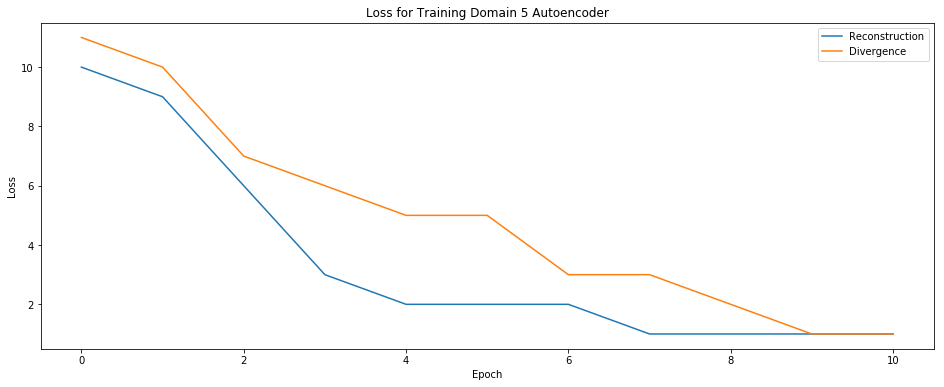

In [184]:
losses1 = [10, 9, 6, 3, 2, 2, 2, 1, 1, 1, 1]
losses2 = [11, 10, 7, 6, 5, 5, 3, 3, 2, 1, 1]

import matplotlib.pyplot as plt

def plotLosses(domain, recLosses, divLosses):

    plt.figure(figsize=(16, 6))
    plt.title('Loss for Training Domain {} Autoencoder'.format(domain))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(recLosses)), recLosses, range(len(divLosses)), divLosses)
    plt.legend(['Reconstruction', 'Divergence'])
    plt.show()

plotLosses(5, losses1, losses2)